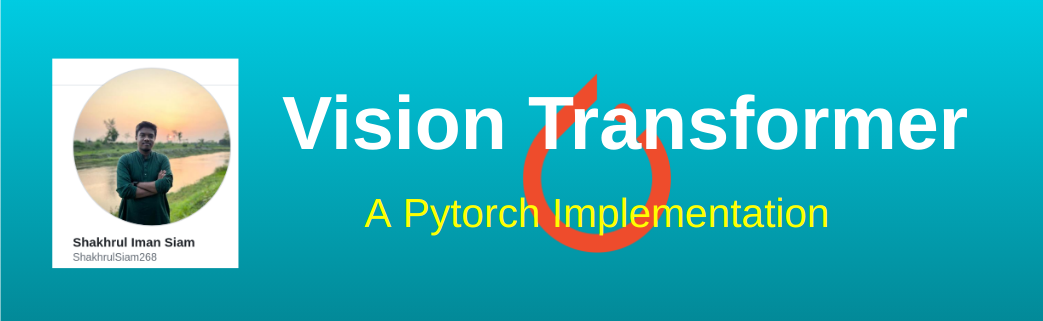

# What is a Vision Transformer?

A Vision Transformer, also known as ViT, is a type of deep learning architecture specifically designed for visual recognition tasks, such as image classification. It was introduced in a research paper titled [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf) published by Dosovitskiy et al. in 2020.

Vision Transformers (ViTs) are based on the Transformer architecture which was originally developed for natural language processing (NLP) tasks. However, ViTs make some key changes to the Transformer architecture to make it better suited for image processing.

Let’s examine the vision transformer architecture step by step.

1. Split an image into patches
1. Flatten the patches
1. Produce lower-dimensional linear embeddings from the flattened patches
1. Add positional embeddings
1. Feed the sequence as an input to a standard transformer encoder
1. Pretrain the model with image labels (fully supervised on a huge dataset)
1. Finetune on the downstream dataset for image classification

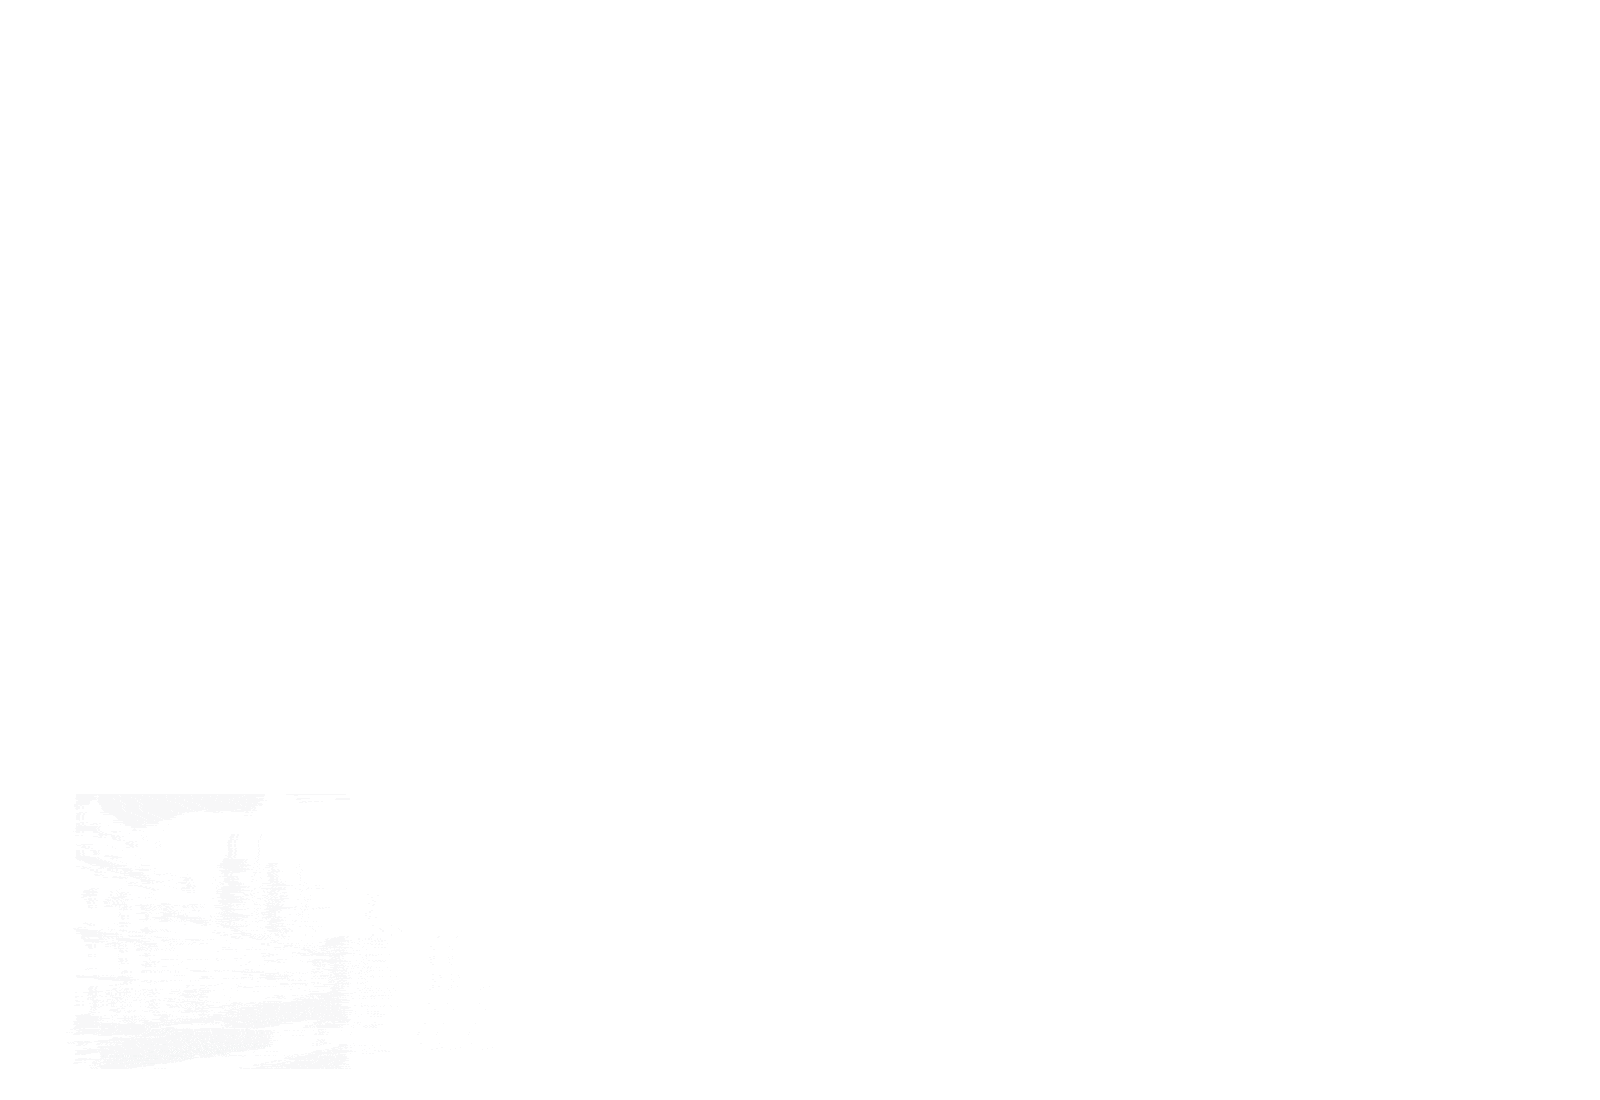

In [4]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# CLS token & Position embedding

Next step is to add the cls token and the position embedding. The cls token is just a number placed in from of each sequence (of projected patches)

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        ) # this breaks down the image in s1xs2 patches, and then flat them
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #prepending the cls token
        x += self.positions
        return x

# Multi Head Attention
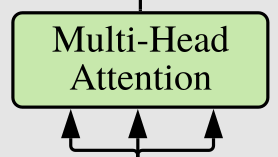

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        
        return out

In [9]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [10]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, L: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, L * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(L * emb_size, emb_size),
        )

# Transformer Encoder Block


In [11]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0., forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):
                 
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, L=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [12]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# Classification head
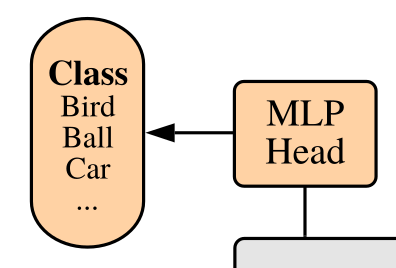

In [13]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

# Tide everything up — VisionTransformer

By composing everything we built so far, we can finally build the ViT architecture.

In [36]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 32,
                emb_size: int = 128,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [15]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [43]:
from torchsummary import summary
print(summary(ViT(), (3,224,224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 7, 7]         393,344
         Rearrange-2              [-1, 49, 128]               0
    PatchEmbedding-3              [-1, 50, 128]               0
         LayerNorm-4              [-1, 50, 128]             256
            Linear-5              [-1, 50, 384]          49,536
           Dropout-6            [-1, 8, 50, 50]               0
            Linear-7              [-1, 50, 128]          16,512
MultiHeadAttention-8              [-1, 50, 128]               0
           Dropout-9              [-1, 50, 128]               0
      ResidualAdd-10              [-1, 50, 128]               0
        LayerNorm-11              [-1, 50, 128]             256
           Linear-12              [-1, 50, 512]          66,048
             GELU-13              [-1, 50, 512]               0
          Dropout-14              [-1, 

In [48]:
# Training settings
batch_size = 64
epochs = 20
lr = 0.01
gamma = 0.7
seed = 42

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [23]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [29]:
train_dir = '/kaggle/input/cat-and-dog/training_set'
test_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

train_list = glob.glob('/kaggle/input/cat-and-dog/training_set/training_set/cats/*.jpg')+glob.glob('/kaggle/input/cat-and-dog/training_set/training_set/dogs/*.jpg')
test_list = glob.glob('/kaggle/input/cat-and-dog/test_set/test_set/cats/*.jpg')+glob.glob('/kaggle/input/cat-and-dog/test_set/test_set/dogs/*.jpg')

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 8005
Test Data: 2023


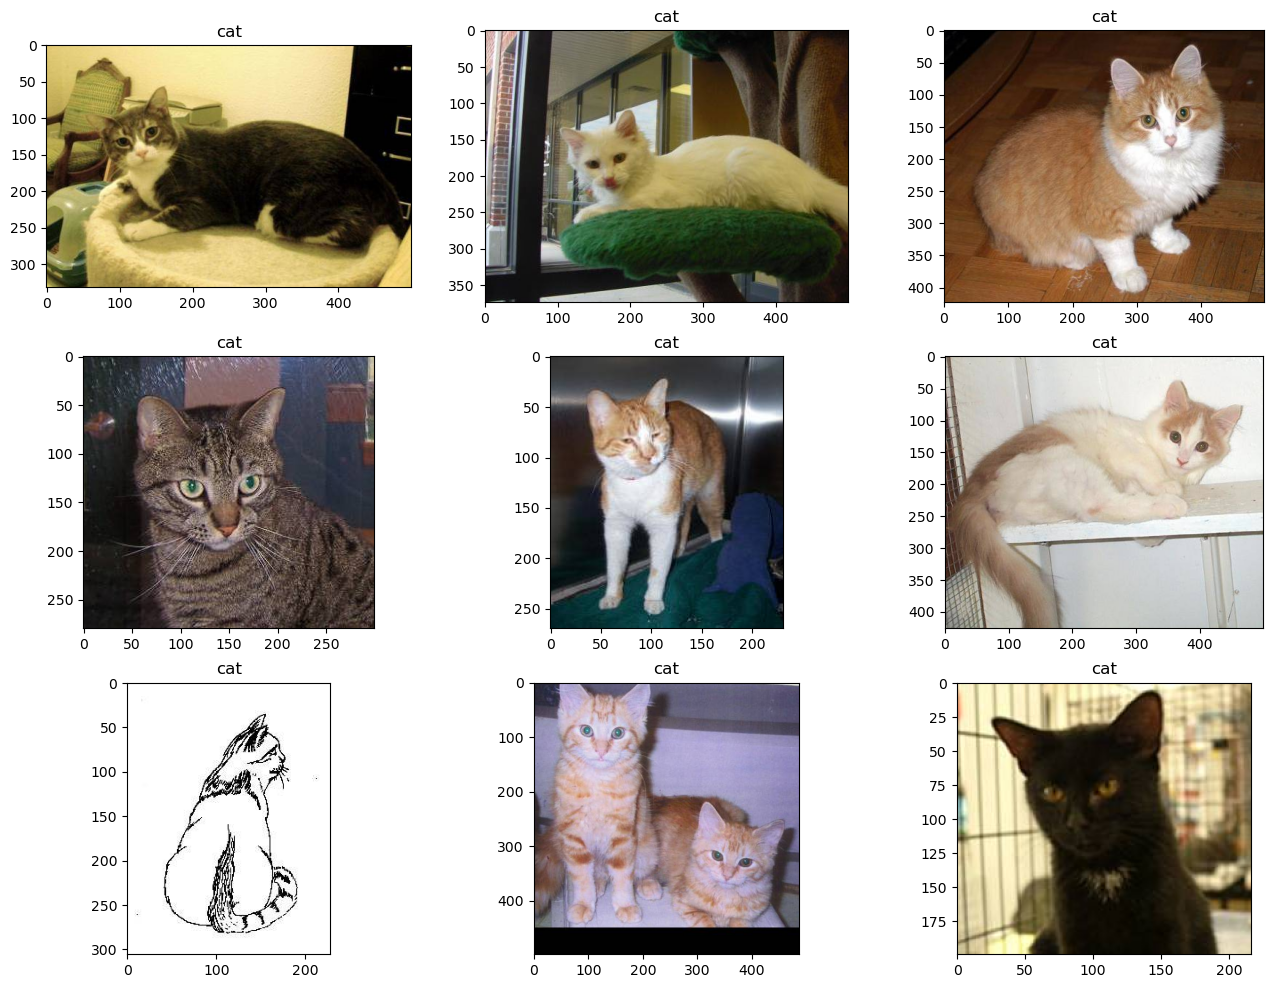

In [26]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [30]:
train_list, valid_list = train_test_split(train_list, test_size=0.2,
                                          stratify=labels,random_state=seed)

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6404
Validation Data: 1601
Test Data: 2023


In [31]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [32]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [33]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [50]:
device='cuda'
model = ViT(in_channels = 3,
                patch_size = 16,
                emb_size = 768,
                img_size  = 224,
                depth = 12,
                n_classes = 2).to(device)

In [51]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [52]:

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2840 - acc: 0.5023 - val_loss : 1.0054 - val_acc: 0.4808



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7445 - acc: 0.5042 - val_loss : 0.7444 - val_acc: 0.5192



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7375 - acc: 0.4958 - val_loss : 0.7864 - val_acc: 0.5186



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7138 - acc: 0.5050 - val_loss : 0.7623 - val_acc: 0.5186



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7163 - acc: 0.5045 - val_loss : 0.7116 - val_acc: 0.4814



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6991 - acc: 0.4989 - val_loss : 0.7212 - val_acc: 0.5192



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6986 - acc: 0.5204 - val_loss : 0.6925 - val_acc: 0.5270



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6957 - acc: 0.5175 - val_loss : 0.6909 - val_acc: 0.5216



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6965 - acc: 0.5003 - val_loss : 0.6936 - val_acc: 0.4820



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6920 - acc: 0.5108 - val_loss : 0.6904 - val_acc: 0.5102



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6911 - acc: 0.5206 - val_loss : 0.6931 - val_acc: 0.5096



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6908 - acc: 0.5282 - val_loss : 0.6902 - val_acc: 0.5114



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6918 - acc: 0.5147 - val_loss : 0.6914 - val_acc: 0.5186



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6891 - acc: 0.5316 - val_loss : 0.6993 - val_acc: 0.4766



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6917 - acc: 0.5213 - val_loss : 0.6904 - val_acc: 0.5126



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6893 - acc: 0.5229 - val_loss : 0.7028 - val_acc: 0.5186



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6922 - acc: 0.5068 - val_loss : 0.6908 - val_acc: 0.5300



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6943 - acc: 0.5084 - val_loss : 0.6952 - val_acc: 0.4880



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6919 - acc: 0.5176 - val_loss : 0.6885 - val_acc: 0.5409



  0%|          | 0/101 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6910 - acc: 0.5139 - val_loss : 0.6906 - val_acc: 0.5355

